# Análisis exploratorio multivariado: correlaciones, covarianzas, PCA

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler, PowerTransformer
from sklearn.decomposition import PCA
from sklearn.covariance import MinCovDet
from scipy.stats import chi2

In [ ]:
variables = df.columns.values
len(variables)

NameError: name 'df' is not defined

In [ ]:
df.info()

### Matriz de correlación de Pearson

In [ ]:
corr_matrix = df.corr(numeric_only=True)
display(corr_matrix)

### Matriz de covarianza

In [ ]:
cov_matrix = df.cov(numeric_only=True)
display(cov_matrix)

Visualización con heatmap

In [ ]:
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Matriz de correlación de las variables numéricas")
plt.show()

### Hacer PCA con todas las variables del archivo limpio

In [ ]:
X = df.dropna()
X = X.drop(columns=['TARGET'])

# normalizar / escalar (para que sea npca)
n = StandardScaler()
X = n.fit_transform(X)

# aplicar pca
pca = PCA()
resultado_pca = pca.fit_transform(X)
componentes = pca.components_

In [ ]:
explicada = pca.explained_variance_ratio_
acumulada = np.cumsum(explicada)

print("Varianza explicada:")
for i, (var, cum_var) in enumerate(zip(explicada, acumulada)):
    print(f"PC{i+1}: {var*100:.1f}% - Acumulada: {cum_var*100:.1f}%")

El valor de la varianza explicada con esta versión del PCA es muy bajo. Se necesitarían 13 componentes principales para poder considerar los resultados cómo útiles.

#### Primeros PC (con todas las variables)

In [ ]:
pc1 = componentes[0]
print("PC1:")
for name, loading in zip(variables, pc1):
    print(f"{name}: {loading:.3f}")

Las variables con más peso en este PC son las tres de los montos: MONTO PREAPROBADO, MONTO APROBADO, MONTO DESEMBOLSO y las dos de saldo: SALDO CAPITAL y SALDO VENCIDO, seguidas de otras un poco menos relevantes como TIEMPO ACTIVIDAD, SCORE y EDAD. Todas son positivas.

Las variables negativas por su lado tienen muy poco peso para considerarse en este PC.

Este PC, al tener sus coeficientes más grandes en los montos (que no es sorpresa, pues son los números más grandes y difieren mucho del rango de valores que el resto de las variables) se puede interpretar como el tamaño del crédito (si este fue preaprobado o aprobado es indistinto, pues ambas variables tienen el mismo peso).

PC1: representa el tamaño del crédito aprovado.

In [ ]:
pc2 = componentes[1]
print("PC2:")
for name, loading in zip(variables, pc2):
    print(f"{name}: {loading:.3f}")

Este PC tiene como variables positivas con mayor peso a las correspondientes a la mora: FRANJA DE MORA y DIAS DE MORA, seguido de PLAZO, TASA y
SALDO VENCIDO.

Por el lado negativo se tienen a EDAD, TIEMPO ACTIVIDAD y SCORE.

No es de sorprender que a mayor la franja de mora, menor será el score. Sin embargo, tiene otros insights interesantes en cuanto a la mora que se verán más a detalle en las siguientes secciones. Lo que sí es que queda claro que  la mora crece junto con el plazo, la tasa y el saldo vencido, lo que puede indicar que una transacción con un valor de PC2 alto es alguien que tendrá un mal score y por ende será un crédito con condiciones no tan buenas lo que está relacionado con la puntualidad con la que se pagará.

PC2: representa el nivel de incumplimiento con las deudas.

In [ ]:
# hacer un scatter plot
scores_pc1 = resultado_pca[:, 0]
scores_pc2 = resultado_pca[:, 1]
plt.figure(figsize=(12, 8))
plt.scatter(scores_pc1, scores_pc2, alpha=0.7, s=60)
for i, (x, y) in enumerate(zip(scores_pc1, scores_pc2)):
    label = f"{df.iloc[i, 0]}".strip()
    plt.annotate(label, (x, y), xytext=(5, 5), textcoords='offset points',
                 fontsize=9, alpha=0.8)
plt.axhline(y=0, color='gray', linestyle='--', alpha=0.5)
plt.axvline(x=0, color='gray', linestyle='--', alpha=0.5)
plt.xlabel(f'PC1 - tamaño del crédito', fontsize=12)
plt.ylabel(f'PC2 - nivel de incumplimiento con deudas', fontsize=12)
plt.title('Observaciones en el Espacio de los Dos Primeros Componentes Principales - transaction ID', fontsize=14)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

En esta gáfica se observa como la cantidad de personas que incumple con sus deudas disminuye a medida de que el monto aprobado sube. Inclusive, una buena parte de los clientes con el valor alto en PC2 tienen un valor de PC1 negativo.

También se puede interpretar como que la clínica tiene un buen método para seleccionar el tamaño de crédito aprobado y que debería concentrar sus esfuerzos en los créditos "pequeños" pues son los que representan la mayor cantidad de dinero por cobrar.

Hay muy poquitos outliers de gente con un gran monto aprovado de crédito y que no pague.

In [ ]:
# hacer un scatter plot
scores_pc1 = resultado_pca[:, 0]
scores_pc2 = resultado_pca[:, 1]
plt.figure(figsize=(12, 8))

# Asegurarnos de que TARGET tiene la misma longitud que los scores PCA
n_samples = resultado_pca.shape[0]
target_for_plot = df['TARGET'].iloc[:n_samples]

# Definir colores discretos: morado para 0, verde para 1
colors = ['purple' if x == 0 else 'green' for x in target_for_plot]

# Crear scatter plot con colores discretos
scatter = plt.scatter(scores_pc1, scores_pc2,
                     c=colors,
                     alpha=0.7,
                     s=60)

plt.axhline(y=0, color='gray', linestyle='--', alpha=0.5)
plt.axvline(x=0, color='gray', linestyle='--', alpha=0.5)
plt.xlabel(f'PC1 - tamaño del crédito', fontsize=12)
plt.ylabel(f'PC2 - nivel de incumplimiento con deudas', fontsize=12)
plt.title('Observaciones en el Espacio de los Dos Primeros Componentes Principales', fontsize=14)
plt.grid(True, alpha=0.3)

# Crear leyenda manual para los colores
from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor='purple', alpha=0.7, label='TARGET = 0'),
    Patch(facecolor='green', alpha=0.7, label='TARGET = 1')
]
plt.legend(handles=legend_elements, loc='best')

plt.tight_layout()
plt.show()

En este gráfico target es igual a uno (verde) si tiene menos de 30 días de mora, es decir, una mora baja. No se alcanza a distinguir una diferencia clara en los datos, aunque se podría decir que hay muchas más moras bajas que altas.

### PCA eliminando variables de monto (dinero)

In [ ]:
ruta_archivo = r"/content/drive/MyDrive/Cinco/yibi/análisis multivariado/avance_datos_numericas.xlsx"

df = pd.read_excel(ruta_archivo)

In [ ]:
variables = [
    "TASA",
    "EDAD",
    "GÉNERO",
    "IDENTIFICACION COMERCIAL",
    "ACTIVOS",
    "GASTOS DE SOSTENIMIENTO",
    "DIAS EN APROBAR",
    "CUOTAMENSUAL",
    "TOTAL INGRESOS",
    "INGRESOS FIJOS",
    "TIPO CONTRATO",
    "CODIGO CIIU",
    "ESTADOCIVIL",
    "NIVEL ESTUDIOS",
    "TIPO VIVIENDA",
    "TIEMPO EN RESIDENCIA",
    "FRANJA DE MORA",
    "DIAS DE MORA",
    "PLAZO",
    "ESTRATO",
    "TIEMPO ACTIVIDAD",
    "SCORE"
]

M = df[variables]

M = M.fillna(0)

# normalizar / escalar (para que sea npca)
n = StandardScaler()
M = n.fit_transform(M)

# aplicar pca
pca = PCA()
resultado_pca = pca.fit_transform(M)
componentes = pca.components_

explicada = pca.explained_variance_ratio_
acumulada = np.cumsum(explicada)

print("Varianza explicada:")
for i, (var, cum_var) in enumerate(zip(explicada, acumulada)):
    print(f"PC{i+1}: {var*100:.1f}% - Acumulada: {cum_var*100:.1f}%")

In [ ]:
pc1 = componentes[0]
print("PC1:")
for name, loading in zip(variables, pc1):
    print(f"{name}: {loading:.3f}")

Aquí las variables positivas más pesadas son TIEMPO ACTIVIDAD, EDAD y SCORE. Por otro lado, en la parte negativa se tiene TASA, PLAZO y TIPO DE VIVIENDA. Esta relación se puede interpretar como que una persona con PC1 bajo correspondería a una persona joven que tendría más plazo y más tasa. O bien, un PC1 alto correspondería a una persona más grande (por ende, también puede tener más tiempo de actividad) y además tendría una menor tasa y un menor plazo.

Además, se observa como las variables de mora son negativas, lo que indica que las personas con PC1 bajo tendrían más días de mora o bien una franja de mora mayor.

Esto podría interpretarse como estabilidad en general, pues el tipo de vivienda (variable negativa en el PC) (1= propia, 4=propia con crédito) y el estado civil (0= soltero, 4 = casado) (variable positiva en el PC) podría indicar (generalizando) que las personas con alto PC1 tienen casa propia sin crédito y son casados. Y que las personas con bajo PC1 son solteros con casa propia a crédito o viven con familiares.

PC1: juntando todos los factores, se interpreta como la estabiilidad de la persona. (estabilidad tradicional o del tipo de la vieja escuela al menos)

In [ ]:
pc2 = componentes[1]
print("PC2:")
for name, loading in zip(variables, pc2):
    print(f"{name}: {loading:.3f}")

Este PC es mucho menos complejo que el anterior, pues todas las variables pesadas son positivas y las más grandes corresponden (por mucho, aprox 0.6) a las variables de la mora.

PC2 = mora

In [ ]:
# hacer un scatter plot
scores_pc1 = resultado_pca[:, 0]
scores_pc2 = resultado_pca[:, 1]
plt.figure(figsize=(12, 8))
plt.scatter(scores_pc1, scores_pc2, alpha=0.7, s=60)
for i, (x, y) in enumerate(zip(scores_pc1, scores_pc2)):
    label = f"{df.iloc[i, 0]}".strip()
    plt.annotate(label, (x, y), xytext=(5, 5), textcoords='offset points',
                 fontsize=9, alpha=0.8)
plt.axhline(y=0, color='gray', linestyle='--', alpha=0.5)
plt.axvline(x=0, color='gray', linestyle='--', alpha=0.5)
plt.xlabel(f'PC1 - estabilidad de la persona', fontsize=12)
plt.ylabel(f'PC2 - mora', fontsize=12)
plt.title('Observaciones en el Espacio de los Dos Primeros Componentes Principales', fontsize=14)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

Se observa como claramente los clientes con menos estabilidad tradicionalmente hablando, o bien, menor PC1 son los que más mora tienen. O por el contrario, que conforme la estabilidad tradicional se alcanza, los niveles altos de mora suavemente desaparecen.

In [ ]:
# hacer un scatter plot
scores_pc1 = resultado_pca[:, 0]
scores_pc2 = resultado_pca[:, 1]
plt.figure(figsize=(12, 8))

# Asegurarnos de que TARGET tiene la misma longitud que los scores PCA
n_samples = resultado_pca.shape[0]
target_for_plot = df['TARGET'].iloc[:n_samples]

# Definir colores discretos: morado para 0, verde para 1
colors = ['purple' if x == 0 else 'green' for x in target_for_plot]

# Crear scatter plot con colores discretos
scatter = plt.scatter(scores_pc1, scores_pc2,
                     c=colors,
                     alpha=0.7,
                     s=60)

plt.axhline(y=0, color='gray', linestyle='--', alpha=0.5)
plt.axvline(x=0, color='gray', linestyle='--', alpha=0.5)
plt.xlabel(f'PC1 - estabilidad de la persona', fontsize=12)
plt.ylabel(f'PC2 - mora', fontsize=12)
plt.title('Observaciones en el Espacio de los Dos Primeros Componentes Principales', fontsize=14)
plt.grid(True, alpha=0.3)

# Crear leyenda manual para los colores
from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor='purple', alpha=0.7, label='TARGET = 0'),
    Patch(facecolor='green', alpha=0.7, label='TARGET = 1')
]
plt.legend(handles=legend_elements, loc='best')

plt.tight_layout()
plt.show()

Usando la misma categoría de target que en el ejercicio anterior, se ven ahora claramente dos grupos marcados. El grupo verde paga a tiempo sus deudas y el morado no.

Sin embargo, no hay diferencia aparente en la estabilidad de las personas en el eje horizontal. Es decir, los grupos se separan verticalmente (pc2), más no horizontalmente (pc1).

Esto nos lleva a explorar otras categorías, como lo es la franja de mora.

In [ ]:
scores_pc1 = resultado_pca[:, 0]
scores_pc2 = resultado_pca[:, 1]
plt.figure(figsize=(12, 8))

# Crear DataFrame temporal para el plotting
plot_df = pd.DataFrame({
    'PC1': scores_pc1,
    'PC2': scores_pc2,
    'FRANJA_DE_MORA': df['FRANJA DE MORA'].iloc[:len(scores_pc1)].astype('category')
})

# Usar seaborn con variable categórica
scatter = sns.scatterplot(data=plot_df, x='PC1', y='PC2',
                         hue='FRANJA_DE_MORA',
                         palette='viridis',  # o 'Set2', 'tab10', etc.
                         alpha=0.7,
                         s=60)

plt.axhline(y=0, color='gray', linestyle='--', alpha=0.5)
plt.axvline(x=0, color='gray', linestyle='--', alpha=0.5)
plt.xlabel(f'PC1 - estabilidad de la persona', fontsize=12)
plt.ylabel(f'PC2 - mora', fontsize=12)
plt.title('Observaciones en el Espacio de los Dos Primeros Componentes Principales\ncoloreado por FRANJA DE MORA', fontsize=14)
plt.grid(True, alpha=0.3)
plt.legend(title='FRANJA DE MORA', loc='best')

plt.tight_layout()
plt.show()

Esta gráfica, coloreada por franja de mora deja claramente la división entre los grupos mostrando como la franja de mora está fuertemente relacionada con el PC2 (cosa que ya se sabía).

Sin embargo, lo interesante está en que conforme la estabilidad de la persona incrementa, la mora se reduce significativamente y viceversa. Se ve como en la linea vertical de pc1 = -6 (que corresponde a personas muy inestables) no hay personas con mora alta. Se debería explorar qué factores se están considerando para autorizarle créditos a las personas con PC1 menor a -5, pues es poco común que paguen sus créditos a tiempo.
Estos factores pueden estar relacionados a la tasa, pues las personas con PC1 bajo tienen mayores tasad, lo cual podría justificar estos créditos.

Con las personas con PC1 mayor a dos sucede algo muy similar, pues son muy muy pocas las personas con PC1 mayor a dos que tengan una franja de mora mayor a siete; indicando que la mora no es un mayor problema con este segmento de la población.

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# gráfico de componentes PCA
def plot_pca_components(components, feature_names, scale=1):
    plt.figure(figsize=(10, 8))

    # PC1 y PC2
    pc1 = components[0, :] * scale
    pc2 = components[1, :] * scale

    # dibujar flechas desde el origen
    for i in range(len(pc1)):
        plt.arrow(0, 0, pc1[i], pc2[i],
                 color='red', alpha=0.7,
                 head_width=0.05, head_length=0.05)
        plt.text(pc1[i] * 1.15, pc2[i] * 1.15,
                feature_names[i], color='darkred',
                ha='center', va='center', fontsize=10)

    # líneas de referencia
    plt.axhline(y=0, color='k', linestyle='--', alpha=0.3)
    plt.axvline(x=0, color='k', linestyle='--', alpha=0.3)

    # configuración
    plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]*100:.1f}%)')
    plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]*100:.1f}%)')
    plt.title('Componentes PCA - Loading Plot')
    plt.grid(alpha=0.3)

    # ajustar límites
    max_val = max(np.abs(pc1).max(), np.abs(pc2).max()) * 1.2
    plt.xlim(-max_val, max_val)
    plt.ylim(-max_val, max_val)

    # círculo de correlación
    circle = plt.Circle((0, 0), 1, color='blue', fill=False, linestyle='--', alpha=0.5)
    plt.gca().add_artist(circle)


plot_pca_components(componentes, variables, scale=3)
plt.show()

Se observa como días de mora y franja de mora apuntan a la misma dirección, lo cual no es sorpresa.

La otra es ver como tiempo de actividad y edad van a la misma dirección, que tampoco es de sorprender pues ambos son tiempo. Una persona de veintiun años no puede tener el tiempo de actividad de una persona de cincuenta si ambos se unieron a los veinte (tendrían 1 vs 29)

Lo que sí es interesante es ver como, con ciertas exepciones, el score y el nivel de estudios apuntan más o menos la misma dirección, indicando que mientras mayor sea el nivel de estudios, mayor score se tiene.

El plazo y la tasa también van muy de la mano, lo que indica cómo mientras crezca el plazo también crece la tasa. Esto tampoco es sorpresa.

El código CIIU (correspondiente a la actividad económica que se tiene), total de ingresos, ingresos fijos y tipo de contrato van en la misma dirección. Estas variables se podrían interpretar como medidores del aspecto de las finanzas personales del paciente.


**Resumen**

Se observa como la mora es más grande en pacientes con menor score crediticio (nadie se sorprendió por eso), pero que además esto va a acompañado de créditos más pequeños, correspondientes a personas jóvenes, que viven con sus familiares o están pagando una casa, con bajo nivel de estudios y además solteros.

Se observan pocas/nulas diferencias entre las personas con franja de mora entre cero y cuatro pero estos grupos sí se comportan distinto que las personas que tienen franja de mora mayor a cinco.

En resumen, los pacientes jóvenes (solteros, sin casa propia y otros créditos) siguen más o menos el siguiente comportamiento (generalizando):

Créditos chicos, a largo plazo y gran tasa  --> gran mora

Nota: es importante notar que la causa de la mora per se no se puede obtener con este análisis (correlation not causation). Es decir, no puede decir que la mora alta que suelen tener estos casos sea causa de la tasa alta ni mucho menos que el alta tasa sea causa de que la mora crezca; pero sí se puede tomar como punto de partida para más análisis futuro.

### PCA sin variables predictoras

In [ ]:
ruta_archivo = r"/content/drive/MyDrive/Cinco/yibi/Reto dentix/BD_numericas.xlsx"

df = pd.read_excel(ruta_archivo)

variables = [
    "TASA",
    "EDAD",
    "GÉNERO",
    "IDENTIFICACION COMERCIAL",
    "ACTIVOS",
    "GASTOS DE SOSTENIMIENTO",
    "DIAS EN APROBAR",
    "CUOTAMENSUAL",
    "TOTAL INGRESOS",
    "INGRESOS FIJOS",
    "TIPO CONTRATO",
    "CODIGO CIIU",
    "ESTADOCIVIL",
    "NIVEL ESTUDIOS",
    "TIPO VIVIENDA",
    "TIEMPO EN RESIDENCIA",
    "PLAZO",
    "ESTRATO",
    "TIEMPO ACTIVIDAD",
    "SCORE"
]

M = df[variables]

M = M.fillna(0)

# normalizar / escalar (para que sea npca)
n = StandardScaler()
M = n.fit_transform(M)

# aplicar pca
pca = PCA()
resultado_pca = pca.fit_transform(M)
componentes = pca.components_

explicada = pca.explained_variance_ratio_
acumulada = np.cumsum(explicada)

print("Varianza explicada:")
for i, (var, cum_var) in enumerate(zip(explicada, acumulada)):
    print(f"PC{i+1}: {var*100:.1f}% - Acumulada: {cum_var*100:.1f}%")

Con este conjunto de variables, la varianza explicada es mejor que con el resto de conjuntos, pues se alcanza el 70% con 11 componentes principales, sin embargo aún así no es un buen indicador.

Antes de analizar los primeros componentes principales, se hizo un scatter plot:

In [ ]:
# hacer un scatter plot
scores_pc1 = resultado_pca[:, 0]
scores_pc2 = resultado_pca[:, 1]
plt.figure(figsize=(12, 8))
plt.scatter(scores_pc1, scores_pc2, alpha=0.7, s=60)
for i, (x, y) in enumerate(zip(scores_pc1, scores_pc2)):
    label = f"{df.iloc[i, 0]}".strip()
    plt.annotate(label, (x, y), xytext=(5, 5), textcoords='offset points',
                 fontsize=9, alpha=0.8)
plt.axhline(y=0, color='gray', linestyle='--', alpha=0.5)
plt.axvline(x=0, color='gray', linestyle='--', alpha=0.5)
plt.xlabel(f'PC1', fontsize=12)
plt.ylabel(f'PC2', fontsize=12)
plt.title('Observaciones en el Espacio de los Dos Primeros Componentes Principales', fontsize=14)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

Claramente se nota que la prescencia de outliers entorpece el proceso de análisis. Se tomó otro enfoque de normalizar los datos para el NPCA, y se busca identificar outliers antes de hacer el PCA.

In [ ]:
df = pd.read_excel(ruta_archivo)

variables = [
    "TASA","EDAD","GÉNERO","IDENTIFICACION COMERCIAL","ACTIVOS",
    "GASTOS DE SOSTENIMIENTO","DIAS EN APROBAR","CUOTAMENSUAL","TOTAL INGRESOS",
    "INGRESOS FIJOS","TIPO CONTRATO","CODIGO CIIU","ESTADOCIVIL","NIVEL ESTUDIOS",
    "TIPO VIVIENDA","TIEMPO EN RESIDENCIA","PLAZO","ESTRATO","TIEMPO ACTIVIDAD","SCORE"
]

data = df[variables]
X0 = data.fillna(0)

# normalizar los datos
pt = PowerTransformer(method='yeo-johnson', standardize=False)
X_t = pt.fit_transform(X0.values)

rs = RobustScaler()
X = rs.fit_transform(X_t)

mcd = MinCovDet(random_state=0).fit(X)
md2 = mcd.mahalanobis(X)

alpha = 0.98 # indica qué tan rigido es el criterio de seleccion de outliers
thr = chi2.ppf(alpha, df=p)
is_outlier = md2 > thr

print(f"{is_outlier.sum()} outliers detectados ({is_outlier.mean():.1%}).")

# PCA con inliers con outliers sobreprestos
pca = PCA(n_components=2, random_state=0)
pca.fit(X[~is_outlier])

scores_all = pca.transform(X)
loadings = pd.DataFrame(pca.components_.T, index=variables, columns=["PC1","PC2"])

Si bien en el gráfico anterior no pareciera que el 16% de los datos fueran outliers, es importante hacerlo con código en lugar de a ojo, pues pasa algo muy interesante cuando con el PCA realizado con los datos "inliers" se grafica para después proyectar sobre esta misma gráfica a los outliers.  

In [ ]:
result = (
    df.loc[X0.index, variables]  # original cols for those rows kept
      .assign(PC1=scores_all[:,0], PC2=scores_all[:,1], MD2=md2, is_outlier=is_outlier)
)

# scatter plot
plt.figure(figsize=(6,5))
mask = ~is_outlier
plt.scatter(result.loc[mask,"PC1"], result.loc[mask,"PC2"], s=12, label="Inliers", alpha=0.8)
plt.scatter(result.loc[~mask,"PC1"], result.loc[~mask,"PC2"], s=30,
            facecolors='none', edgecolors='red', linewidths=1, label="Outliers")

plt.xlabel("PC1"); plt.ylabel("PC2"); plt.title("PCA (MCD inliers)")
plt.legend()
plt.grid(True, linewidth=0.3, alpha=0.5)
plt.show()

Se observan dos cosas:

La primera es que hay grupos muy bien definidos. Esto es una buena señal porque se puede considerar (prematuramente) que el PCA funcionó y logró reducir la dimensionalidad de los datos sin necesariamente perder información. Esto se valida con el porcentaje de varianza explicada:

In [ ]:
print("Varianza explicada en PC1 y PC2):", pca.explained_variance_ratio_)
print("Acumulada:", pca.explained_variance_ratio_.sum())

Cuando se hizo el PCA con todas las variables del archivo original, los primeros dos PC únicamente explicaban el 24.4% de la varianza; a diferencia de este, que explica casi el 45%. Esto es una buena señal, sigue sin ser el 70% ideal, pero es seña de una mejora considerable en la calidad del análisis.

La segunda cosa que se observa, es que hay un empalme en la gran mayoría de estos grupos (azul y rojo), a exepción de los valores que en el PC1 están entre cuatro y seis. Esto es señal de que los outliers, aunque estaban entorpeciendo la generación del PCA correctamente, sí tienen información valiosa que debe investigarse a más detalle. En este punto la hipotesis sería que los grupos formados corresponden a la franja de mora, pero es imposible saber a estas alturas, pues todavía no se analiza el significado de cada PC.

In [ ]:
# ver las cargas de pc1 y pc2
loadings.sort_values("PC1", key=abs, ascending=False)

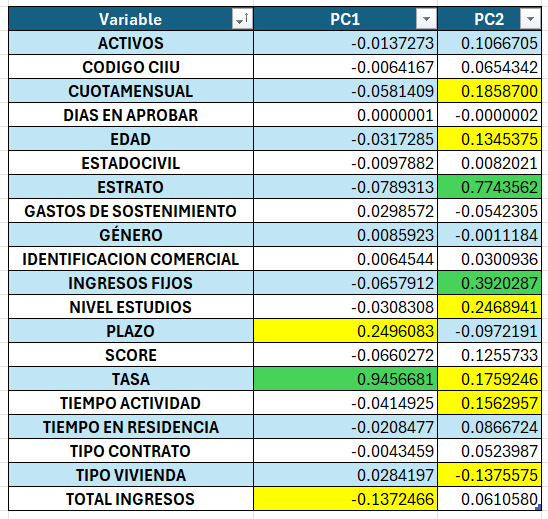

En términos de PC1, la variable con más peso es la tasa. A mayor tasa, mayor es PC1. Se ve como a medida que la tasa crece, también crece el plazo. En la dirección opuesta se tiene el total de ingresos, indicando como las personas con más ingresos suelen tener la tasa ligeramente más baja. Este PC es el tamaño de la tasa.

En términos de PC2, el estrato y ingresos son lo que más pesa. Mientras mayor sean los ingresos y el estrato socioeconómico de la persona, mayor es el PC2. Los estudios, la couta mensual, la tasa, entre otros también se mueven en esta dirección con menor peso. Este PC es el del éxito económico. Mientras mayor sea esta métrica, más estabilidad y mejor salario.

Ahora que ya se conoce el significado de los PCs, se puede graficar con la mora, para validar la hipótesis que se tiene sobre la relación de los grupos con la franja de mora:

In [ ]:
franja = (
    df.loc[X0.index, 'FRANJA DE MORA']
      .astype('category')
)
plot_df = pd.DataFrame({
    'PC1': scores_all[:, 0],
    'PC2': scores_all[:, 1],
    'FRANJA_DE_MORA': franja
}).dropna(subset=['FRANJA_DE_MORA'])

cats = plot_df['FRANJA_DE_MORA'].cat.remove_unused_categories().cat.categories

plt.figure(figsize=(7, 6))
for cat in cats:
    sub = plot_df[plot_df['FRANJA_DE_MORA'] == cat]
    plt.scatter(sub['PC1'], sub['PC2'], s=35, alpha=0.7, label=str(cat))

plt.axhline(0, ls='--', lw=0.8, color='gray', alpha=0.6)
plt.axvline(0, ls='--', lw=0.8, color='gray', alpha=0.6)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('Observaciones en PC1–PC2 coloreado por FRANJA DE MORA')
plt.grid(True, alpha=0.3)
plt.legend(title='FRANJA DE MORA', frameon=True)
plt.tight_layout()
plt.show()

Se observa como la franja de mora tiene poca relación con la segmentación de estos grupos. Aún así, se puede separar por categoría para ver si hay alguna relación oculta:

NameError: name 'plot_df' is not defined

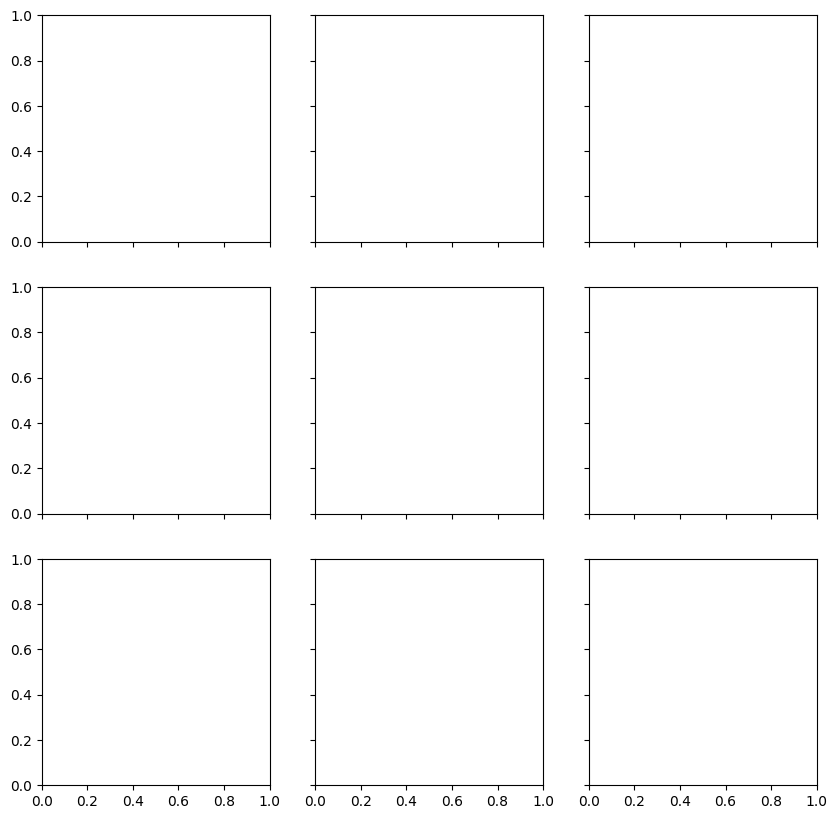

In [ ]:
xlo, xhi = -8, 8
ylo, yhi = -8, 8

fig, axes = plt.subplots(3, 3, figsize=(10, 10), sharex=True, sharey=True)

for v in range(9):
    r, c = divmod(v, 3)
    ax = axes[r, c]
    sub = plot_df[fdm_num == v]

    if len(sub):
        ax.scatter(sub['PC1'], sub['PC2'], s=18, alpha=0.8)
    else:
        ax.text(0.5, 0.5, "No data", ha='center', va='center', transform=ax.transAxes)

    ax.axhline(0, ls='--', lw=0.6, color='gray', alpha=0.6)
    ax.axvline(0, ls='--', lw=0.6, color='gray', alpha=0.6)
    ax.set_xlim(xlo, xhi); ax.set_ylim(ylo, yhi)
    ax.grid(True, alpha=0.3)
    ax.set_title(f'FRANJA DE MORA = {v} (n={len(sub)})', fontsize=10)

for ax in axes[:, 0]:
    ax.set_ylabel('PC2')
for ax in axes[-1, :]:
    ax.set_xlabel('PC1')

plt.tight_layout()
plt.show()

Y no, parece ser que, si bien hay grupos dentro de los PCs, estos no tienen nada que ver con la franja de mora.